![1_CIFAR-10   VGG16 for Image Detection](https://github.com/user-attachments/assets/e2711c61-9221-4dfa-b474-ae3e7ff8d3f6)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

# CIFAR-10 High-Resolution Image Display Script

This script organizes and displays510 high-resolution images for each CIFAR-10 class in a grid format. Each row represents a distinct CIFAR-10 category (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with the class label displayed in the first column. Images are resized to 64x64 pixels with nearest-neighbor interpolation, ensuring clear, non-blurry visuals. The script provides a structured and easily comparable view of sample images, useful for visual dataset analysis and model testing.


Files already downloaded and verified


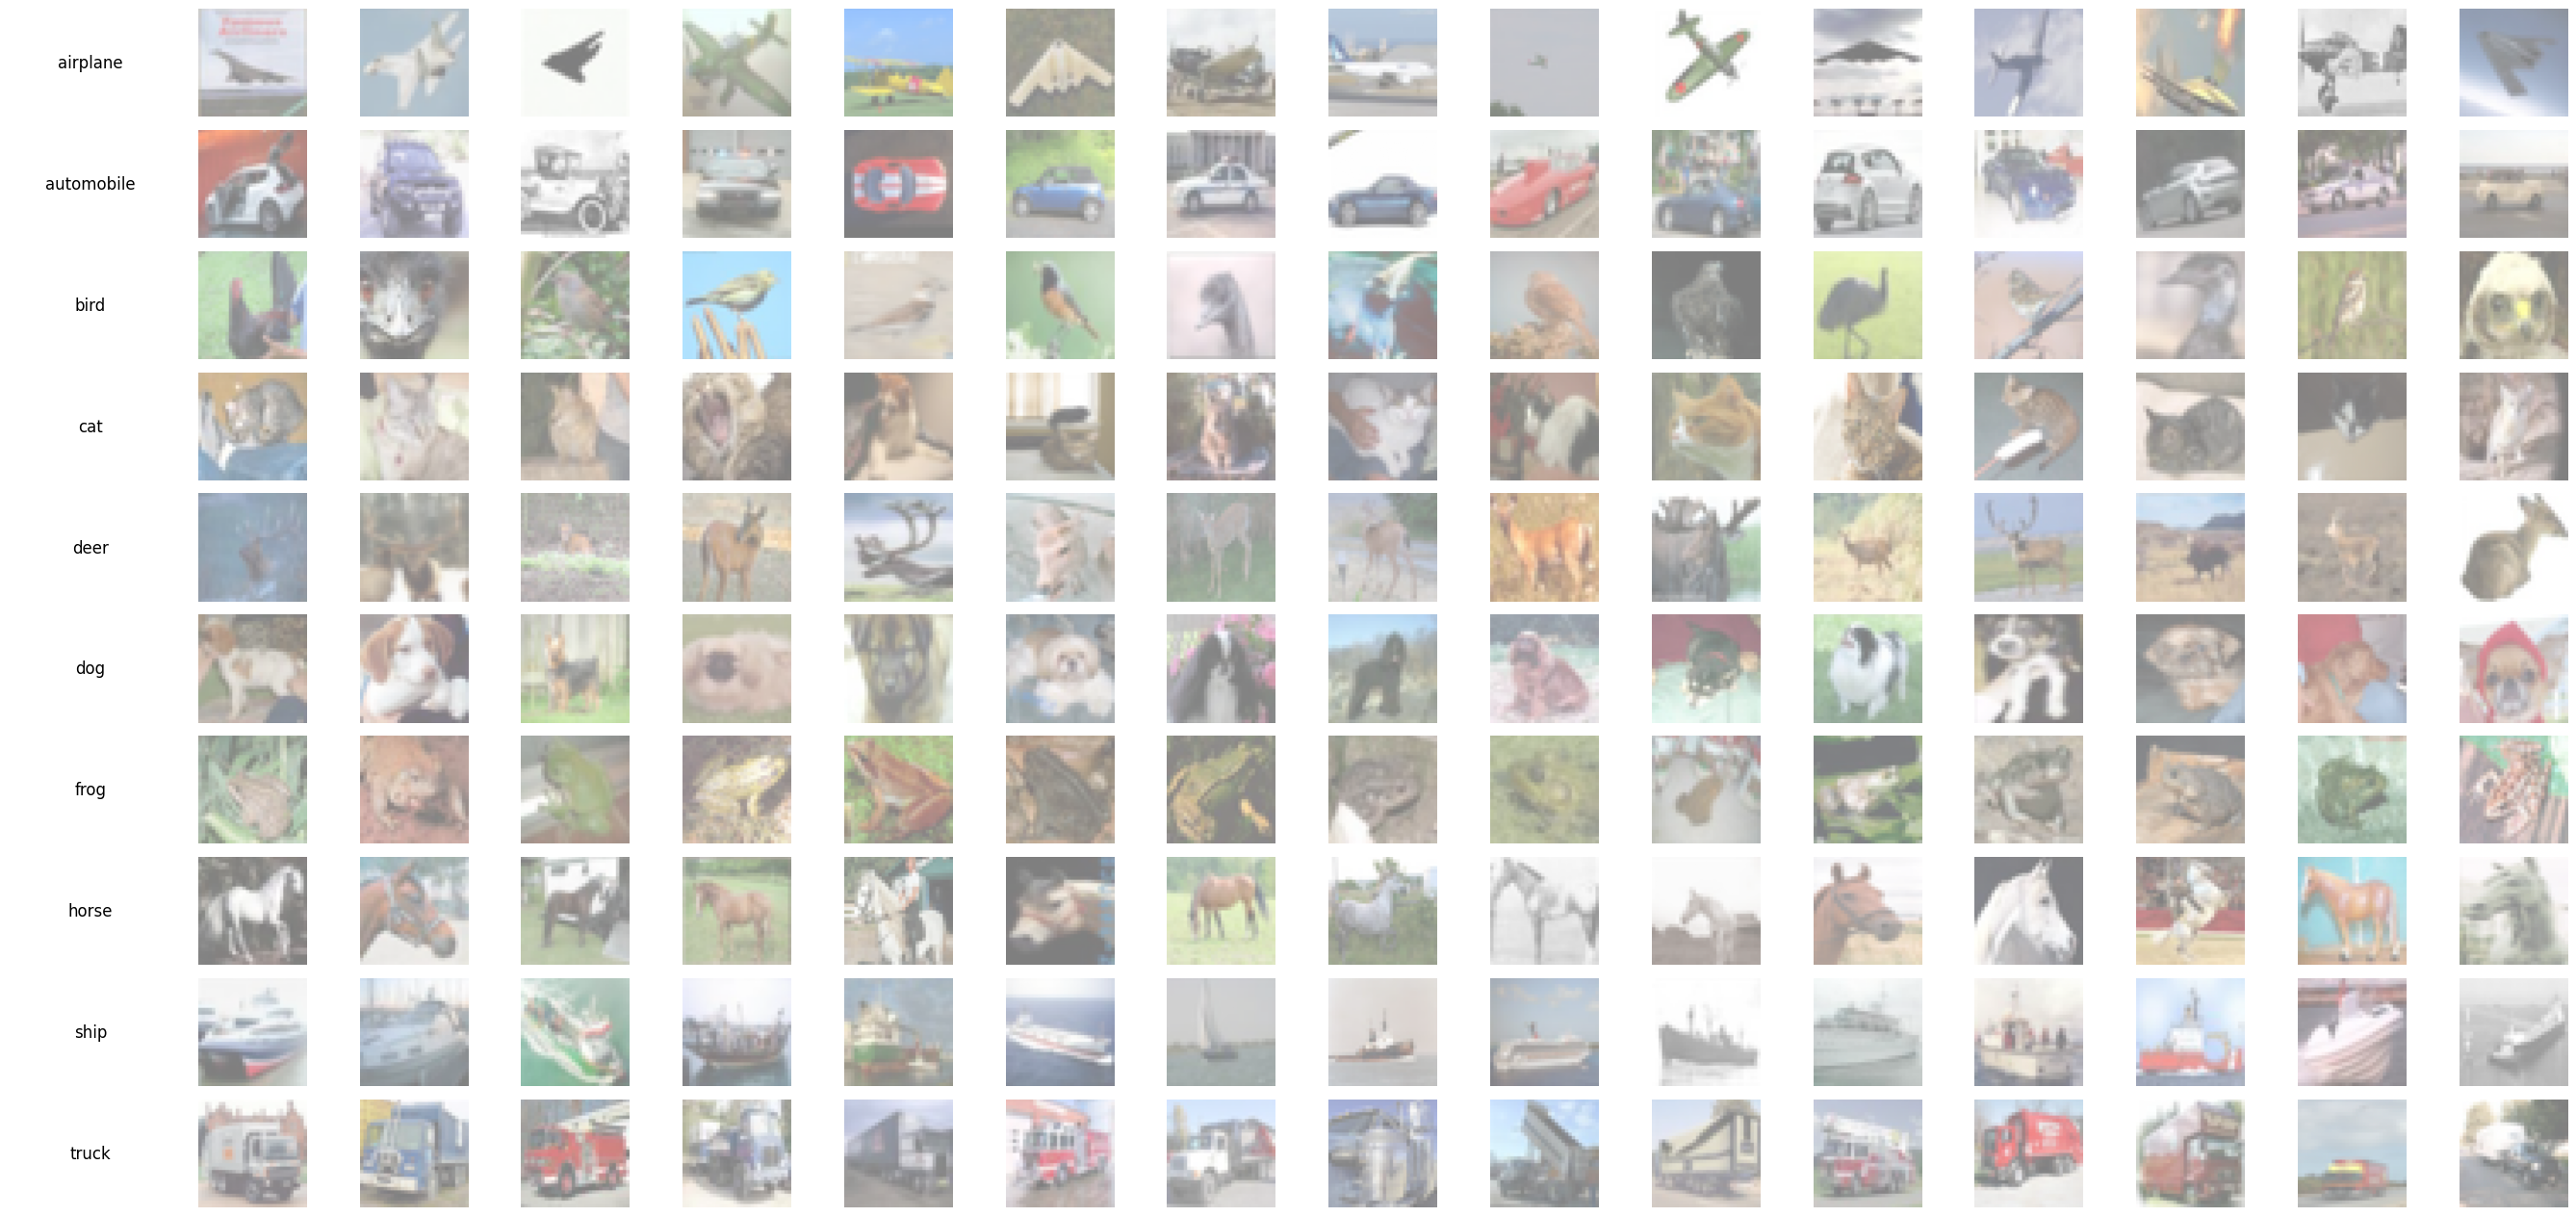

In [13]:
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.NEAREST),  # Increase size without blurring
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

samples_per_class = 15
class_samples = {class_name: [] for class_name in cifar10_classes}

for img, label in dataset:
    class_name = cifar10_classes[label]
    if len(class_samples[class_name]) < samples_per_class:
        class_samples[class_name].append(img)
    if all(len(samples) == samples_per_class for samples in class_samples.values()):
        break

fig, axes = plt.subplots(len(cifar10_classes), samples_per_class + 1, figsize=(30, 14))

for row, class_name in enumerate(cifar10_classes):
    axes[row, 0].text(0.5, 0.5, class_name, fontsize=12, ha='center', va='center')
    axes[row, 0].axis('off')
    for col in range(samples_per_class):
        img_tensor = class_samples[class_name][col]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * 0.5) + 0.5
        axes[row, col + 1].imshow(img_np)
        axes[row, col + 1].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9, left=0.1)
plt.show()


# Define the architecture type and VGG configuration dictionary

In [15]:
VGG_types = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

#  VGG -16 model for CIFAR-10


The VGG-16 network is a deep convolutional neural network architecture, known for its simplicity and uniform use of 3x3 convolution layers followed by 2x2 max-pooling layers. This table outlines the structure of each layer and its function.

| Layer Type               | Configuration                                                                                                  | Output Shape       | Description                                                                                               |
|--------------------------|-----------------------------------------------------------------------------------------------------------------|--------------------|-----------------------------------------------------------------------------------------------------------|
| Input Layer              | -                                                                                                               | 3 x 32 x 32       | CIFAR-10 input image (3 channels for RGB, 32x32 resolution)                                               |
| Convolution + ReLU       | Conv2D(3, 64, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                   | 64 x 32 x 32      | First 3x3 convolution layer with 64 filters, padding for same output size, followed by ReLU activation.   |
| Convolution + ReLU       | Conv2D(64, 64, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                  | 64 x 32 x 32      | Another 3x3 convolution layer with 64 filters, followed by ReLU.                                          |
| Max Pooling              | MaxPool2d(kernel_size=2, stride=2)                                                                             | 64 x 16 x 16      | 2x2 max-pooling reduces spatial dimensions by half.                                                       |
| Convolution + ReLU       | Conv2D(64, 128, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                 | 128 x 16 x 16     | 3x3 convolution layer with 128 filters, followed by ReLU.                                                 |
| Convolution + ReLU       | Conv2D(128, 128, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 128 x 16 x 16     | Another 3x3 convolution layer with 128 filters, followed by ReLU.                                         |
| Max Pooling              | MaxPool2d(kernel_size=2, stride=2)                                                                             | 128 x 8 x 8       | 2x2 max-pooling reduces spatial dimensions by half.                                                       |
| Convolution + ReLU       | Conv2D(128, 256, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 256 x 8 x 8       | 3x3 convolution with 256 filters, followed by ReLU.                                                       |
| Convolution + ReLU       | Conv2D(256, 256, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 256 x 8 x 8       | Another 3x3 convolution with 256 filters.                                                                 |
| Convolution + ReLU       | Conv2D(256, 256, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 256 x 8 x 8       | Additional 3x3 convolution with 256 filters, followed by ReLU.                                            |
| Max Pooling              | MaxPool2d(kernel_size=2, stride=2)                                                                             | 256 x 4 x 4       | 2x2 max-pooling reduces spatial dimensions by half.                                                       |
| Convolution + ReLU       | Conv2D(256, 512, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 512 x 4 x 4       | 3x3 convolution with 512 filters.                                                                         |
| Convolution + ReLU       | Conv2D(512, 512, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 512 x 4 x 4       | Another 3x3 convolution with 512 filters.                                                                 |
| Convolution + ReLU       | Conv2D(512, 512, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 512 x 4 x 4       | Additional 3x3 convolution with 512 filters.                                                              |
| Max Pooling              | MaxPool2d(kernel_size=2, stride=2)                                                                             | 512 x 2 x 2       | 2x2 max-pooling reduces spatial dimensions by half.                                                       |
| Convolution + ReLU       | Conv2D(512, 512, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 512 x 2 x 2       | Final block: 3x3 convolution with 512 filters.                                                            |
| Convolution + ReLU       | Conv2D(512, 512, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 512 x 2 x 2       | Another 3x3 convolution layer with 512 filters.                                                           |
| Convolution + ReLU       | Conv2D(512, 512, kernel_size=3, padding=1) + BatchNorm2d + ReLU                                                | 512 x 2 x 2       | Additional 3x3 convolution with 512 filters.                                                              |
| Max Pooling              | MaxPool2d(kernel_size=2, stride=2)                                                                             | 512 x 1 x 1       | Final 2x2 max-pooling layer.                                                                              |
| Flatten                  | -                                                                                                               | 512               | Flatten output for fully connected layers.                                                                |
| Fully Connected + ReLU   | Linear(512, 4096) + ReLU + Dropout(p=0.5)                                                                      | 4096              | First fully connected layer with dropout for regularization.                                              |
| Fully Connected + ReLU   | Linear(4096, 4096) + ReLU + Dropout(p=0.5)                                                                     | 4096              | Second fully connected layer with ReLU and dropout.                                                       |
| Output Layer             | Linear(4096, num_classes)                                                                                      | 10                | Output layer for CIFAR-10 classification, producing 10 class scores.                                      |


In [16]:
class VGG_net(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):  # Set num_classes to 10 for CIFAR-10
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types['VGG16'])
        
        # Fully connected layers, adjusted for CIFAR-10 (assuming final feature map of size 1x1 after pooling)
        self.fcs = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output from conv layers
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [
                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.BatchNorm2d(x),
                    nn.ReLU()
                ]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
                
        return nn.Sequential(*layers)

In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model = VGG_net(in_channels=3, num_classes=10).to(device)


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


# Training loop

Epoch [1/20]


100%|██████████| 782/782 [00:23<00:00, 33.54it/s]


Training Loss: 1.9571, Test Loss: 1.7984
Epoch [2/20]


100%|██████████| 782/782 [00:22<00:00, 35.00it/s]


Training Loss: 1.6541, Test Loss: 1.5435
Epoch [3/20]


100%|██████████| 782/782 [00:22<00:00, 34.56it/s]


Training Loss: 1.4568, Test Loss: 1.4408
Epoch [4/20]


100%|██████████| 782/782 [00:22<00:00, 34.69it/s]


Training Loss: 1.2094, Test Loss: 1.1938
Epoch [5/20]


100%|██████████| 782/782 [00:22<00:00, 34.84it/s]


Training Loss: 0.9869, Test Loss: 0.9122
Epoch [6/20]


100%|██████████| 782/782 [00:22<00:00, 34.80it/s]


Training Loss: 0.8365, Test Loss: 1.0654
Epoch [7/20]


100%|██████████| 782/782 [00:22<00:00, 34.86it/s]


Training Loss: 0.7245, Test Loss: 0.7362
Epoch [8/20]


100%|██████████| 782/782 [00:22<00:00, 35.04it/s]


Training Loss: 0.6327, Test Loss: 0.6957
Epoch [9/20]


100%|██████████| 782/782 [00:22<00:00, 35.10it/s]


Training Loss: 0.5632, Test Loss: 0.6156
Epoch [10/20]


100%|██████████| 782/782 [00:22<00:00, 35.01it/s]


Training Loss: 0.4960, Test Loss: 0.5620
Epoch [11/20]


100%|██████████| 782/782 [00:22<00:00, 34.81it/s]


Training Loss: 0.4329, Test Loss: 0.5609
Epoch [12/20]


100%|██████████| 782/782 [00:23<00:00, 33.68it/s]


Training Loss: 0.3924, Test Loss: 0.5917
Epoch [13/20]


100%|██████████| 782/782 [00:22<00:00, 34.88it/s]


Training Loss: 0.3406, Test Loss: 0.6157
Epoch [14/20]


100%|██████████| 782/782 [00:22<00:00, 34.83it/s]


Training Loss: 0.3169, Test Loss: 0.5133
Epoch [15/20]


100%|██████████| 782/782 [00:22<00:00, 34.51it/s]


Training Loss: 0.2691, Test Loss: 0.5559
Epoch [16/20]


100%|██████████| 782/782 [00:22<00:00, 34.80it/s]


Training Loss: 0.2301, Test Loss: 0.6082
Epoch [17/20]


100%|██████████| 782/782 [00:22<00:00, 34.95it/s]


Training Loss: 0.2436, Test Loss: 0.6413
Epoch [18/20]


100%|██████████| 782/782 [00:22<00:00, 35.15it/s]


Training Loss: 0.1915, Test Loss: 0.6281
Epoch [19/20]


100%|██████████| 782/782 [00:22<00:00, 35.24it/s]


Training Loss: 0.1682, Test Loss: 0.6345
Epoch [20/20]


100%|██████████| 782/782 [00:22<00:00, 35.12it/s]


Training Loss: 0.1471, Test Loss: 0.6480


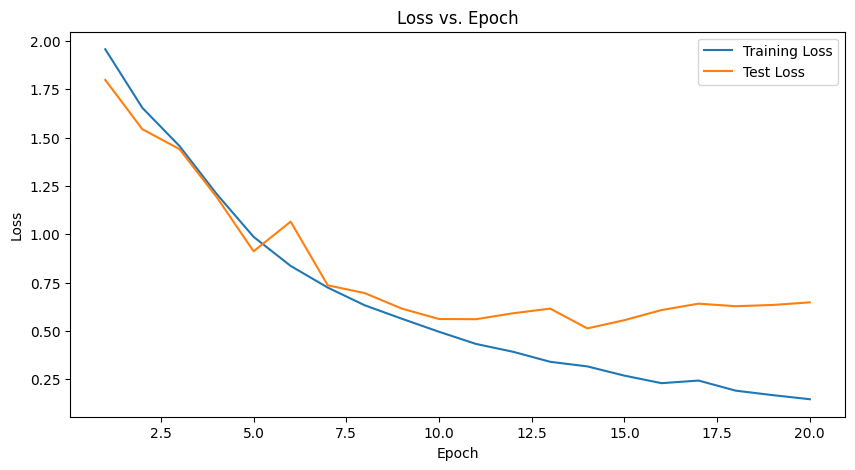

In [18]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    
   
    model.train()  
    train_loss = 0
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device=device)
        targets = targets.to(device=device)

      
        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
   
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

 
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

          
            scores = model(data)
            loss = criterion(scores, targets)
            test_loss += loss.item()

   
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

In [21]:
# Function to check accuracy on the given data loader
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)  # Get index of max log-probability
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)

    model.train()  # Set model back to training mode
    return num_correct / num_samples

# Checking accuracy
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}%")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}%")

Accuracy on training set: 96.55%
Accuracy on test set: 84.39%


In [29]:
# Lists to store metrics for both training and testing sets
metrics = {'train': {}, 'test': {}}

def evaluate_model(loader, model):
    all_preds = []
    all_targets = []
    model.eval()
    
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)
            
            scores = model(data)
            _, preds = scores.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    conf_matrix = confusion_matrix(all_targets, all_preds)
    
    return accuracy, precision, f1, conf_matrix

# Evaluate on the training set
metrics['train']['accuracy'], metrics['train']['precision'], metrics['train']['f1'], metrics['train']['conf_matrix'] = evaluate_model(train_loader, model)

# Evaluate on the test set
metrics['test']['accuracy'], metrics['test']['precision'], metrics['test']['f1'], metrics['test']['conf_matrix'] = evaluate_model(test_loader, model)

# Print the metrics
print(f"Training Accuracy: {metrics['train']['accuracy']:.4f}, Precision: {metrics['train']['precision']:.4f}, F1 Score: {metrics['train']['f1']:.4f}")
print(f"Testing Accuracy: {metrics['test']['accuracy']:.4f}, Precision: {metrics['test']['precision']:.4f}, F1 Score: {metrics['test']['f1']:.4f}")


Training Accuracy: 0.9655, Precision: 0.9663, F1 Score: 0.9654
Testing Accuracy: 0.8439, Precision: 0.8464, F1 Score: 0.8431


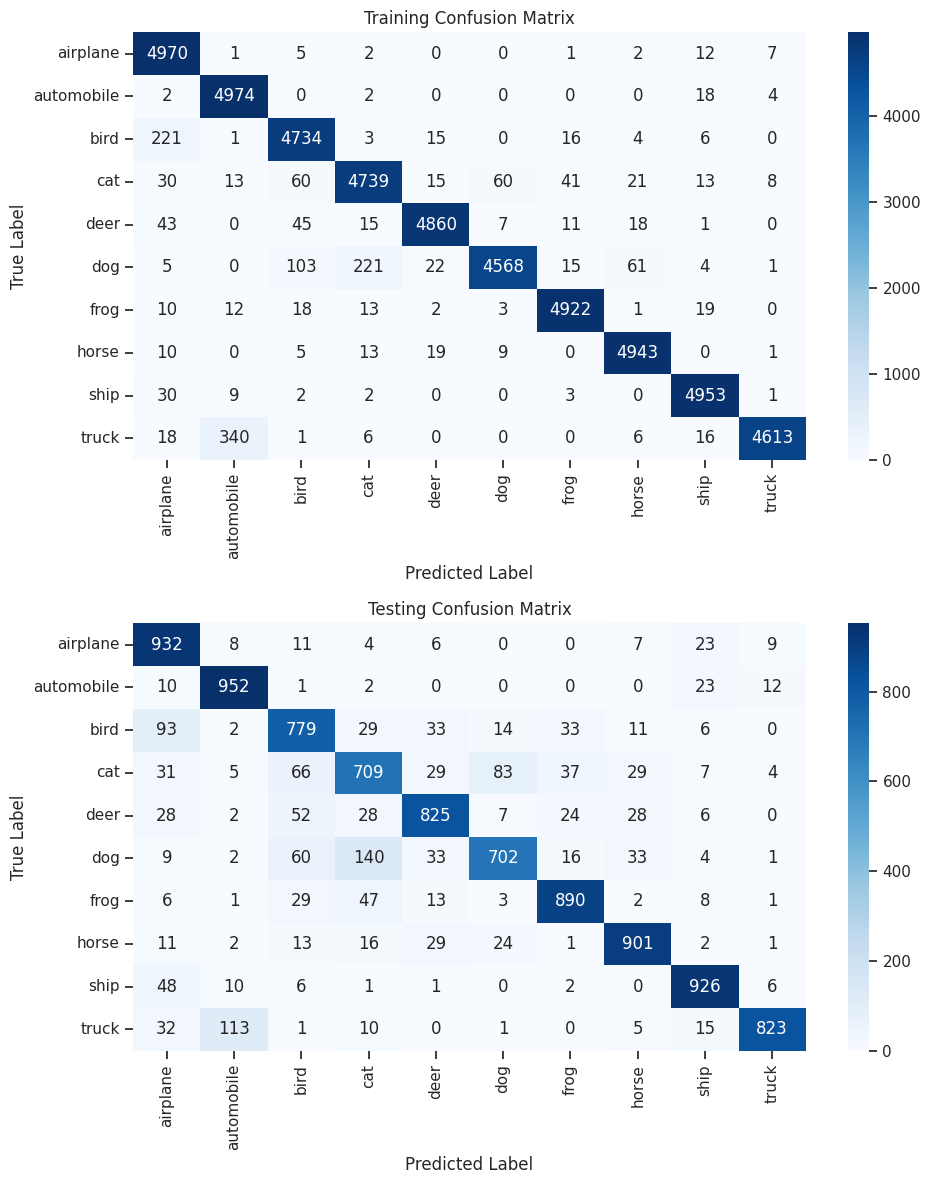

In [30]:
# Plot confusion matrix for training and testing
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
sns.heatmap(metrics['train']['conf_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(2, 1, 2)
sns.heatmap(metrics['test']['conf_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

In [3]:
# Save only the model's state_dict (recommended approach for PyTorch models)
torch.save(model.state_dict(), "vgg16_cifar10_state_dict.pth")